# Counting blobs with pyclesperanto
A common use case for image processing in the biology context is counting blobs of high signal intensity surrounded by a low intensity background. Thresholding is the method of choice in this scenario. We demonstrate it with Otsu's thresholding method (Otsu et al., IEEE Transactions on Systems, Man, and Cybernetics, Vol. 9 (1), 1979)

In [1]:
import pyclesperanto_prototype as cle

from skimage.io import imread, imsave, imshow
import matplotlib
import numpy as np

# initialize GPU
cle.select_device("GTX")

<Intel(R) Iris(R) Xe Graphics on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

In [2]:
# load data
image = imread('https://samples.fiji.sc/blobs.png')
print("Loaded image size: " + str(image.shape))

# push image to GPU memory
input = cle.push(image)
print("Image size in GPU: " + str(input.shape))

Loaded image size: (254, 256)
Image size in GPU: (254, 256)


## Image processing using pyclesperanto

After initializing GPU and pushing images there, workflows are constructed like this:

cl.OCLArray([[ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
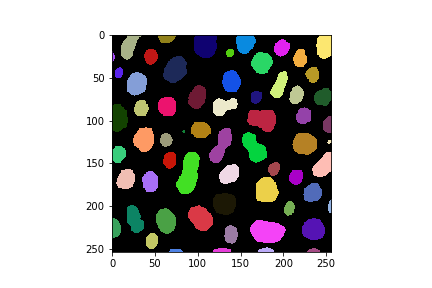

In [3]:
# process the image
blurred = cle.gaussian_blur(input, sigma_x=1, sigma_y=1)
binary = cle.threshold_otsu(blurred)
labeled = cle.connected_components_labeling_box(binary)
labeled

In [4]:
# The maximium intensity in a label image corresponds to the number of objects
num_labels = cle.maximum_of_all_pixels(labeled)
print("Number of objects in the image: " + str(num_labels))

Number of objects in the image: 62.0


When processing multiple images subsequently, it might make sense to re-use memory like shown in the following. In that way, some time can be spared for not re-allocating images over and over.

cl.OCLArray([[ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
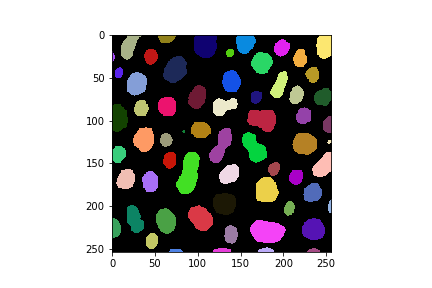

In [5]:
# process the image
blurred = cle.gaussian_blur(input, blurred, sigma_x=1, sigma_y=1)
binary = cle.threshold_otsu(blurred, binary)
labeled = cle.connected_components_labeling_box(binary, labeled)
labeled

## Addendum: Remove labels on edges
In case the size of the objects is relevant, one should exclude the object which were not fully imaged and thus, touch the image border.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
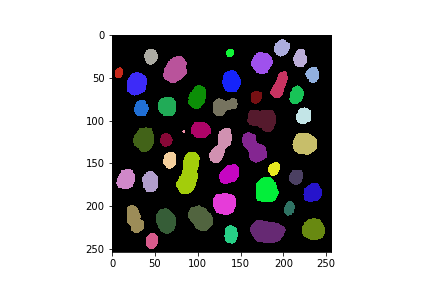

In [6]:
# Exclude Labels On Edges
labels_excl_edges = cle.exclude_labels_on_edges(labeled)
labels_excl_edges